In [1]:
import geopandas as gpd
import pandas as pd
import folium
import json
from folium import plugins
from IPython.display import display
from IPython.display import HTML, display
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.style.use('ggplot')
print('libraries imported')

libraries imported


# Load data

In [15]:
toulouse_geo_dir = 'C:/Users/amaur/OneDrive/Documents/Data science/MOOC/MOOC coursera/capstone/valeurs foncières/recensement-population-2016-grands-quartiers-logement.geojson'
print('data_loaded')

data_loaded


# Read the geography in the global file

In [16]:
with open(toulouse_geo_dir, 'r') as j:
     toulouse_geo = json.loads(j.read())
print('toulouse_geo ok')

toulouse_geo ok


In [27]:
# Check the structure of the Geojson file (uncomment next line of code)
#toulouse_geo

# Load the file with data of interest and Cleaning UP

In [19]:
toulouse = pd.read_csv('C:/Users/amaur/OneDrive/Documents/Data science/MOOC/MOOC coursera/capstone/data_toulouse_foncier.csv')
print('data loaded')

data loaded


In [20]:
# Check the structure of the dataset (uncomment next line of code)
toulouse.drop('Unnamed: 0', axis=1, inplace=True) # Clean_up file
toulouse.head()

valeur_fonciere nom_commune  code_postal     id_parcelle  \
0            73000    Toulouse        31000  31555818AB0043   
1           140000    Toulouse        31200  31555831BC0687   
2            76000    Toulouse        31400  31555813AD0294   
3            90000    Toulouse        31000  31555818AB0732   
4           350057    Toulouse        31000  31555827AD0187   

   nombre_pieces_principales  surface_terrain   type_local  \
0                          1              NaN  Appartement   
1                          4            225.0       Maison   
2                          0              NaN  Appartement   
3                          2              NaN  Appartement   
4                          3             90.0       Maison   

   surface_reelle_bati  longitude   latitude       quartier      prix_m2  
0                 17.0   1.438402  43.602411       CAPITOLE  4294.117647  
1                 77.0   1.446339  43.644810  CROIX-DAURADE  1818.181818  
2                 12.0   1.445320  43.586255   SAINT-MICHEL  6333.333333  
3                 30.0   1.440546  43.601473       CAPITOLE  3000.000000  
4                 59.0   1.425701  43.607076    AMIDONNIERS  5933.169492

In [21]:
# OPtional modofy the name of the variable containing the neighborhoods'names so that it matches with the attribute in the
# Geojson file
toulouse = toulouse.rename(columns={'quartier':'libelle_du_grand_quartier'})

In [22]:
# As we will need a mean price by Neigborhood for the m2, we need to group the data by Neigborhood
toulouse_gp_mean = toulouse.groupby(['libelle_du_grand_quartier']).mean().sort_values('prix_m2', ascending=False)
toulouse_gp_mean = toulouse_gp_mean.reset_index()

In [23]:
#Check the structure of the dataset
print(len(toulouse_gp_mean))
toulouse_gp_mean.head()

59


libelle_du_grand_quartier  valeur_fonciere  code_postal  \
0                    ARENES     4.421067e+06      31100.0   
1                   COMPANS     5.292947e+05      31000.0   
2                 GINESTOUS     1.923409e+06      31200.0   
3              JULES JULIEN     4.158965e+05      31400.0   
4             SAINT-GEORGES     3.052549e+05      31000.0   

   nombre_pieces_principales  surface_terrain  surface_reelle_bati  longitude  \
0                   2.666667       615.000000           168.333333   1.417504   
1                   2.866667       450.833333            99.535714   1.429158   
2                   1.818182      5159.600000          2823.181818   1.418160   
3                   3.454545       405.875000            84.400000   1.450735   
4                   1.421053              NaN            75.459459   1.447730   

    latitude       prix_m2  
0  43.589673  37778.568848  
1  43.609162   8638.786471  
2  43.649147   5640.427418  
3  43.575829   5573.710471  
4  43.603557   5299.098011

# Descriptive statistics

In [24]:
# Check which neibourhood has the most transactions
toulouse_gp_count = toulouse.groupby(['libelle_du_grand_quartier']).count().sort_values('id_parcelle', ascending=False)
toulouse_gp_count.head()

valeur_fonciere  nom_commune  code_postal  \
libelle_du_grand_quartier                                              
CROIX-DAURADE                          102          102          102   
MINIMES                                 95           95           95   
GUILHEMERY                              91           91           91   
LES CHALETS                             81           81           81   
COTE PAVEE                              81           81           81   

                           id_parcelle  nombre_pieces_principales  \
libelle_du_grand_quartier                                           
CROIX-DAURADE                      102                        102   
MINIMES                             95                         95   
GUILHEMERY                          91                         91   
LES CHALETS                         81                         81   
COTE PAVEE                          81                         81   

                           surface_terrain  type_local  surface_reelle_bati  \
libelle_du_grand_quartier                                                     
CROIX-DAURADE                           91         102                   99   
MINIMES                                 56          95                   88   
GUILHEMERY                              43          91                   87   
LES CHALETS                             17          81                   75   
COTE PAVEE                              61          81                   78   

                           longitude  latitude  prix_m2  
libelle_du_grand_quartier                                
CROIX-DAURADE                    102       102       99  
MINIMES                           95        95       88  
GUILHEMERY                        91        91       87  
LES CHALETS                       81        81       75  
COTE PAVEE                        81        81       78

## Descriptive statistics for the dependant variable

In [10]:
toulouse['prix_m2'].describe()

count      2003.000000
mean       3998.551919
std        5539.331856
min           0.000000
25%        2637.604895
50%        3500.000000
75%        4460.497685
max      190909.090909
Name: prix_m2, dtype: float64

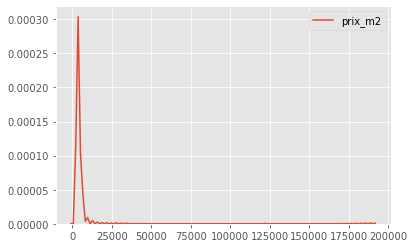

In [11]:
sns.kdeplot(toulouse['prix_m2'])

# Geomapping of toulouse data

In [12]:
## latitude and longitude de toulouse
LAT_tlse = 43.6043
LON_tlse = 1.4437

In [13]:
# Set up the basis for the map
toulouse_map = folium.Map(location=[LAT_tlse, LON_tlse], zoom_start=12)

In [14]:
# map point of the sales units
sales = folium.map.FeatureGroup()
for lat, long in zip(toulouse.latitude, toulouse.longitude):
    sales.add_child(
        folium.CircleMarker(
            [lat,long],
            radius=2,
            color = 'yellow',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.6
        )
    )

In [30]:
# add pop-up text(sales value) to each marker on the map 
latitudes = list(toulouse.latitude)
longitudes = list(toulouse.longitude)
labels = list(toulouse.valeur_fonciere)

for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker([lat, lng], popup=label).add_to(toulouse_map) 

#add sales to map
toulouse_map.add_child(sales)

## The map might not the most easy to read due to the number of observations (clustering them on next map)

In [15]:
toulouse_map = folium.Map(location=[LAT_tlse, LON_tlse], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
sales = plugins.MarkerCluster().add_to(toulouse_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(toulouse.latitude, toulouse.longitude, toulouse.valeur_fonciere):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(sales)

In [16]:
# Display map
toulouse_map

## Choropleth map of neigbourhoods mean values (€/km2)

In [33]:
# Set up a threshold to the different class of neigbourhood based on quantile distribution of the dependant variable
bins = list(toulouse['prix_m2'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1]))

In [34]:
# Base map
toulouse_map = folium.Map(location=[LAT_tlse, LON_tlse], zoom_start=12)

In [37]:
toulouse_map.choropleth(
    geo_data = toulouse_geo, # Specify the geographic file
    data = toulouse_gp_mean, # Specify the file with data to plot
    columns=['libelle_du_grand_quartier', 'prix_m2'], # Within dataset to plot specify which columns, first geo_name, second variable to plot
    key_on='feature.properties.libelle_du_grand_quartier', # Within the geojson get the feature to associate with the vars
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Mean price per m2',
    bins=bins,
    reset=True
)

# Adding clustered point for a full featured map
sales = plugins.MarkerCluster().add_to(toulouse_map)
for lat, lng, label, in zip(toulouse.latitude, toulouse.longitude, toulouse.valeur_fonciere):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(sales)

In [38]:
# Display map
toulouse_map